<a href="https://colab.research.google.com/github/jiukeem/deeplearning_from_scratch/blob/master/%EC%84%B1%EB%8A%A5%ED%96%A5%EC%83%81%EB%B0%A9%EB%B2%95%EB%93%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import numpy as np

In [2]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
sgd = SGDClassifier(loss='log', max_iter=200, tol=1e-3, random_state=42)

In [5]:
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)
# 83프로에서 향상시키고 싶다면? 첫번째로 loss 파라미터를 바꿔보자

0.8333333333333334

In [6]:
sgd2 = SGDClassifier(loss='hinge', max_iter=200, tol=1e-3, random_state=42)

In [7]:
sgd2.fit(x_train, y_train)
sgd2.score(x_test, y_test)
# 퍼포먼스를 더 늘리고 싶으면? 이제 하이퍼파라미터를 조정해보자

0.9385964912280702

In [8]:
# 기존의 Logistic Unit에서 learning rate 추가
class LogisticUnit:
  def __init__(self, learning_rate = 0.1):
    self.w = None
    self.b = None
    self.cost_change = []
    self.w_history = []
    self.lr = learning_rate

  def initialize_para(self, x):
    self.w = np.ones(x.shape[1])
    self.b = 0
    return self.w, self.b

  def forward_prop(self, x):
    z = np.sum(x * self.w) + self.b # x.shape = (1, nx), w.shape = (1, nx), b.shape = (1, 1) 아니면 float 이라고 쓰는게 맞나?
    a = self.sigmoid(z) # z와 a, y 모두 실수
    return a

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def back_prop(self, x, y, a):
    dw = x * (a - y)
    db = 1 * (a - y)
    return dw, db

  def fit(self, x, y, epoch=100):
    self.w, self.b = self.initialize_para(x)
    for i in range(epoch):
      cost = 0
      for x_i, y_i in zip(x, y):        
        a = self.forward_prop(x_i)
        dw, db = self.back_prop(x_i, y_i, a)
        self.w = self.w - self.lr * dw
        self.b = self.b - self.lr * db
        a = np.clip(a, 1e-10, 1-1e-10)
        loss = -(y_i * np.log(a) + (1 - y_i) * np.log(1 - a))
        cost += loss
        self.w_history.append(self.w.copy()) # 넘파이 배열을 리스트에 추가하면 실제 값이 복사되는게 아니라 배열을 참조하기 때문에 복사해서 추가
      cost = cost / x.shape[0]
      self.cost_change.append(cost)


  def predict(self, x, y):
    a = [self.forward_prop(x_i) for x_i in x]
    y_hat = [i > 0.5 for i in a]
    accuracy = np.mean([y_hat == y])
    return accuracy

In [9]:
unit = LogisticUnit()

In [10]:
unit.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


In [11]:
unit.predict(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


0.8157894736842105

In [12]:
w2 = [w[2] for w in unit.w_history]
w3 = [w[3] for w in unit.w_history]

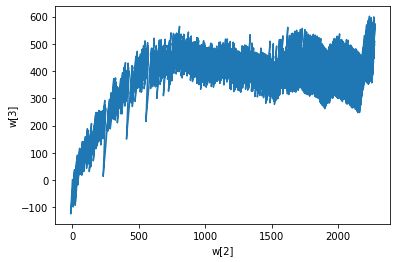

In [13]:
import matplotlib.pyplot as plt

plt.plot(w2, w3)
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# converge 하면서 w3이 너무 많이 왔다갔다하는게 눈에 보인다 (w3의 벨류 범위가 굉장)
# input normalization 을 해줍시다

In [14]:
cancer.feature_names[2]

'mean perimeter'

In [15]:
x_mean = np.mean(x, axis=0) # 열끼리 더하고 싶으니까 axis=0
x_std = np.std(x, axis=0)

In [16]:
x_scaled = (x - x_mean) / x_std

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

In [18]:
unit.fit(x_train, y_train)

In [19]:
unit.predict(x_test, y_test)
# 와우 성능이 어마무시하게 좋아졌네요

0.9824561403508771

In [38]:
# 러닝커브를 그려보자
class LogisticUnit2:
  def __init__(self, learning_rate = 0.1):
    self.w = None
    self.b = None
    self.cost_change = []
    self.w_history = []
    self.lr = learning_rate
    self.val_cost_change = []

  def initialize_para(self, x):
    self.w = np.ones(x.shape[1])
    self.b = 0
    return self.w, self.b

  def forward_prop(self, x):
    z = np.sum(x * self.w) + self.b # x.shape = (1, nx), w.shape = (1, nx), b.shape = (1, 1) 아니면 float 이라고 쓰는게 맞나?
    a = self.sigmoid(z) # z와 a, y 모두 실수
    return a

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def back_prop(self, x, y, a):
    dw = x * (a - y)
    db = 1 * (a - y)
    return dw, db

  def fit(self, x, y, epoch=100, x_val=None, y_val=None):
    self.w, self.b = self.initialize_para(x)
    for i in range(epoch):
      cost = 0
      for x_i, y_i in zip(x, y):        
        a = self.forward_prop(x_i)
        dw, db = self.back_prop(x_i, y_i, a)
        self.w = self.w - self.lr * dw
        self.b = self.b - self.lr * db
        a = np.clip(a, 1e-10, 1-1e-10)
        loss = -(y_i * np.log(a) + (1 - y_i) * np.log(1 - a))
        cost += loss
        self.w_history.append(self.w.copy()) # 넘파이 배열을 리스트에 추가하면 실제 값이 복사되는게 아니라 배열을 참조하기 때문에 복사해서 추가
      cost = cost / x.shape[0]
      self.cost_change.append(cost)
      self.update_val(x_val, y_val)

  def update_val(self, x_val, y_val):
    if x_val is None:
      return
    val_cost = 0
    for x_i, y_i in zip(x_val, y_val):
      a = self.forward_prop(x_i)
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = -(y_i * np.log(a) + (1 - y_i) * np.log(1 - a))
      val_cost += loss
    val_cost /= x_val.shape[0]
    self.val_cost_change.append(val_cost)

  def predict(self, x, y):
    a = [self.forward_prop(x_i) for x_i in x]
    y_hat = [i > 0.5 for i in a]
    accuracy = np.mean([y_hat == y])
    return accuracy

In [32]:
unit2 = LogisticUnit2()

In [33]:
unit2.fit(x_train, y_train, x_val = x_test, y_val = y_test)

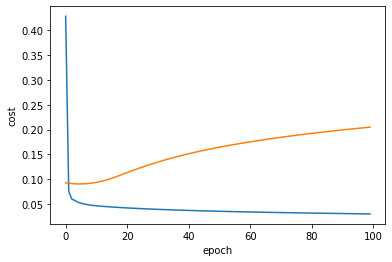

In [35]:
plt.plot(unit2.cost_change)
plt.plot(unit2.val_cost_change)
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()
# 10에포크 이후로는 오버피팅된다고 보면 되는건가?

In [36]:
unit2.val_cost_change[:10]

[0.09252584277225315,
 0.09247829408071478,
 0.0908992423710259,
 0.09064110317892186,
 0.09040794815067298,
 0.09038434422061147,
 0.09071608379844065,
 0.09107186378823803,
 0.09173241724728246,
 0.09252316890629833]

In [43]:
unit3 = LogisticUnit2()
unit3.fit(x_train, y_train, epoch=10)

In [44]:
unit3.predict(x_test, y_test) # 오 진짜 향상됐잖아???! 짱이다

0.9912280701754386